In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import xroms
# from cartopy import geodesic  # FS only way to get this module
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import numpy as np
import cmocean.cm as cmo
from xgcm import Grid
import cmocean.cm as cmo
import matplotlib.gridspec as gridspec

In [2]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=3)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
def load_roms():
    # A basic chunk choice
    chunks = {'ocean_time': 10}
    glb_files = glob('/g/data/fu5/deg581/SA_model/ocean_his_garkgw_2018_full.nc')
    ds = xr.open_mfdataset(glb_files, chunks=chunks, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right')
    print('Loading data: OK!')
    return ds




def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def rho_eos(Tt,Ts,z_r):
    #     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # %
    # % function [rho,bvf]=rho_eos(Tt,Ts,z_r)
    # %
    # % Computes density via Equation Of State (EOS) for seawater.
    # % If so prescribed, non-linear EOS of Jackett and McDougall (1995)
    # % is used.
    # %
    # % Tt potential temperature [deg Celsius].
    # % Ts salinity [PSU].
    # % Tz pressure/depth, [depth in meters and negative].
    # %
    # % K0, K1 and K2 are the pressure polynomial coefficients for secant
    # % bulk modulus, so that
    # %
    # %               bulk = K0 - K1 * z + K2 * z**2 ;
    # %
    # % while rho1 is sea-water density [kg/m^3] at standard pressure
    # % of 1 Atm, so that the density anomaly at in-sity pressure is
    # %
    # %               rho = rho1 / (1 + z / bulk) - 1000
    # %
    # %  Reference:
    # %
    # %  Jackett, D. R. and T. J. McDougall, 1995, Minimal Adjustment of
    # %  Hydrostatic Profiles to Achieve Static Stability, Journ of Atmos.
    # %  and Oceanic Techn., vol. 12, pp. 381-389.
    # %
    # % << This equation of state formulation has been derived by Jackett
    # %    and McDougall (1992), unpublished manuscript, CSIRO, Australia.
    # %    It computes in-situ density anomaly as a function of potential
    # %    temperature (Celsius) relative to the surface, salinity (PSU),
    # %    and depth (meters).  It assumes  no  pressure  variation along
    # %    geopotential  surfaces,  that  is,  depth  and  pressure  are
    # %    interchangeable. >>
    # %                                          John Wilkin, 29 July 92
    # %
    # % Check Values: T=3 C S=35.5 PSU Z=-5000 m rho=1050.3639165364 
    
    import numpy as np
    
    A00=+19092.56;A01=+209.8925;
    A02=-3.041638;A03=-1.852732e-3;A04=-1.361629e-5;A10=104.4077;
    A11=-6.500517;A12=+0.1553190;A13=2.326469e-4;AS0=-5.587545;
    AS1=+0.7390729;AS2=-1.909078e-2;B00=+4.721788e-1;B01=+1.028859e-2;
    B02=-2.512549e-4;B03=-5.939910e-7;B10=-1.571896e-2;B11=-2.598241e-4;
    B12=+7.267926e-6;BS1=+2.042967e-3;E00=+1.045941e-5;E01=-5.782165e-10;
    E02=+1.296821e-7;E10=-2.595994e-7;E11=-1.248266e-9;E12=-3.508914e-9;

    QR=+999.842594;Q01=+6.793952e-2;Q02=-9.095290e-3;
    Q03=+1.001685e-4;Q04=-1.120083e-6;Q05=+6.536332e-9;Q10=+0.824493;
    Q11=-4.08990e-3;Q12=+7.64380e-5;Q13=-8.24670e-7;Q14=+5.38750e-9;
    QS0=-5.72466e-3;QS1=+1.02270e-4;QS2=-1.65460e-6;Q20=+4.8314e-4;
    
    
    sqrtTs=np.sqrt(Ts);

    K0=A00+Tt*(A01+Tt*(A02+Tt*(A03+Tt*A04)))+Ts*(A10+Tt*(A11+Tt*(A12+Tt*A13))+sqrtTs*(AS0+Tt*(AS1+Tt*AS2)));
    K1=B00+Tt*(B01+Tt*(B02+Tt*B03))+Ts*(B10+Tt*(B11+Tt*B12)+sqrtTs*BS1);
    K2=E00+Tt*(E01+Tt*E02)+Ts*(E10+Tt*(E11+Tt*E12));
    rho1=QR+Tt*(Q01+Tt*(Q02+Tt*(Q03+Tt*(Q04+Tt*Q05))))+Ts*(Q10+Tt*(Q11+Tt*(Q12+Tt*(Q13+Tt*Q14)))+sqrtTs*(QS0+Tt*(QS1+Tt*QS2))+Ts*Q20);
    rho=rho1/(1+0.1*z_r/(K0-z_r*(K1-z_r*K2)));
    
    return rho


#### load data, make grid file, correct vertical coordinate


In [4]:
# # correct calendar in SA roms file
# ds = xr.open_dataset('/g/data/fu5/deg581/SA_model/ocean_his_garkgw_2018_full.nc', decode_times=False)
# ds.ocean_time.attrs['calendar'] = 'proleptic_gregorian'
# ds.dstart.attrs['calendar'] = 'proleptic_gregorian'

# ds = xr.decode_cf(ds, decode_times=True).sel(ocean_time=slice('2018-01-01','2018-02-01',2))

In [5]:
dap_url = "https://dapds00.nci.org.au/thredds/dodsC/fx3/model_data/gbr1_2.0.ncml"
ds = xr.open_dataset(dap_url)

In [6]:
ds

<xarray.Dataset>
Dimensions:      (k: 44, j: 2389, i: 510, time: 70935)
Coordinates:
    zc           (k) float64 ...
    longitude    (j, i) float64 ...
    latitude     (j, i) float64 ...
  * time         (time) datetime64[ns] 2014-11-30T14:00:00 ... 2022-11-26T12:...
Dimensions without coordinates: k, j, i
Data variables: (12/16)
    botz         (j, i) float64 ...
    eta          (time, j, i) float32 ...
    u            (time, k, j, i) float32 ...
    v            (time, k, j, i) float32 ...
    w            (time, k, j, i) float32 ...
    salt         (time, k, j, i) float32 ...
    ...           ...
    RT_expose    (time, k, j, i) float32 ...
    dhw0         (time, k, j, i) float32 ...
    dhw1         (time, k, j, i) float32 ...
    dhw2         (time, k, j, i) float32 ...
    dhw3         (time, k, j, i) float32 ...
    swr          (time, j, i) float32 ...
Attributes: (12/13)
    title:                    GBR1 Hydro
    description:              eReefs GBR 1k grid with rivers. Uses JCU bathy ...
    paramhead:                GBR 1km resolution grid
    paramfile:                ./prm/gbr1_hydro_nrt.prm
    ems_version:              v1.4.0 rev(6949)
    date_created:             Tue Nov 29 04:38:54 2022
    ...                       ...
    Run_ID:                   2.1
    Run_code:                 GBR1 Hydro|G0.00|H2.10|S0.00|B0.00
    Parameter_File_Revision:  $Revision$
    bald__isPrefixedBy:       prefix_list
    prefix_list_puv__:        https://w3id.org/env/puv#
    prefix_list_qudt__:       http://qudt.org/vocab/unit/

In [7]:
ufull = ds.u.sel(time=slice('2018-01-01','2018-02-01',2))
vfull = ds.v.sel(time=slice('2018-01-01','2018-02-01',2))

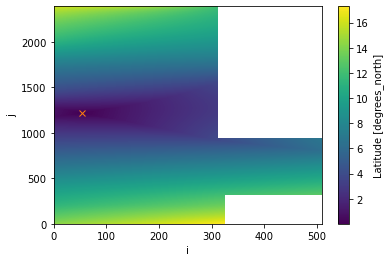

In [8]:
# Cleveland bay Townsville
qlon=146.86646
qlat=-19.28743
# abs(u.longitude-qlon).plot()
# plt.show()
# (abs(u.latitude-qlat)+abs(u.longitude-qlon)).plot()
closest_approach = (abs(ufull.latitude-qlat)+abs(ufull.longitude-qlon)).argmin(dim=['j','i'])
q_i = closest_approach["i"].values
q_j = closest_approach["j"].values

(abs(ufull.latitude-qlat)+abs(ufull.longitude-qlon)).plot()
plt.plot(q_i,q_j,'x',color='C1')

In [9]:
# subset data for the single site
u = ufull.isel(i=q_i,j=q_j)
v = vfull.isel(i=q_i,j=q_j)
vmag = (u**2 + v**2)**0.5

# subset for depth
q_depth = -4
print(u.zc.isel(k=q_depth).values)
vmag_bot = vmag.isel(k=q_depth)

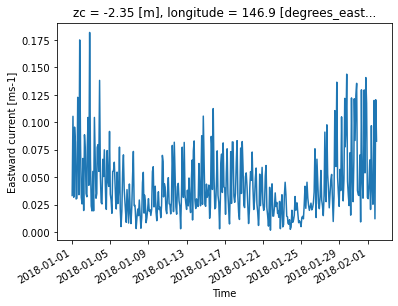

flow length-scale at Cleveland Bay


3672.491204738617

In [20]:
vmag_bot.plot()
plt.show()
print('flow length-scale at Cleveland Bay')
(vmag_bot.mean(dim='time').values*(24*60*60))

148.261284
-20.030284


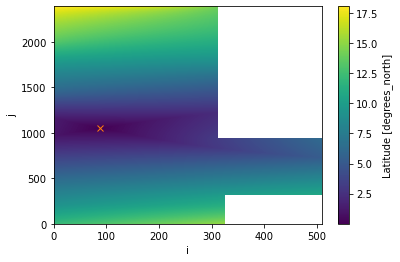

In [43]:
# Bowen
# qlon=148.26532
# qlat=-20.02545
qlon=148.25466
qlat=-20.02412
qlon=148.26145
qlat=-20.03
closest_approach = (abs(ufull.latitude-qlat)+abs(ufull.longitude-qlon)).argmin(dim=['j','i'])
q_i = closest_approach["i"].values
q_j = closest_approach["j"].values

(abs(ufull.latitude-qlat)+abs(ufull.longitude-qlon)).plot()
plt.plot(q_i,q_j,'x',color='C1')

# q_i=q_i-1

print(ufull.longitude.isel(i=q_i,j=q_j).values)
print(ufull.latitude.isel(i=q_i,j=q_j).values)

In [44]:
# subset data for the single site
u = ufull.isel(i=q_i,j=q_j)
v = vfull.isel(i=q_i,j=q_j)
vmag = (u**2 + v**2)**0.5

# subset for depth
q_depth = -4
print(u.zc.isel(k=q_depth).values)
vmag_bot = vmag.isel(k=q_depth)

-2.35


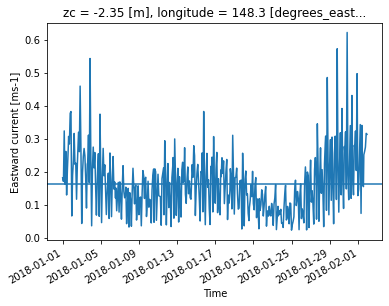

flow length-scale at Bowen


14159.245347976685

In [45]:
vmag_bot.plot()
plt.axhline(vmag_bot.mean(dim='time'))
plt.show()
print('flow length-scale at Bowen')
(vmag_bot.mean(dim='time').values*(24*60*60))


In [12]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
ds = ds.drop_vars(['AKs','w','vbar','ubar'])


In [ ]:
ds.nbytes/1e9

In [ ]:
# ds = load_roms()
ds = processROMSGrid(ds)
grid = makeROMSGridObject(ds)

In [ ]:
ds = ds.drop_vars(['zeta','z_u','z_v','dz_w','dz_u','dz_w_u','dz_v','dz_w_v','dz','z_w'])

ds.nbytes/1e9

In [ ]:
ds

In [ ]:

ds.load()

#### Simple plots of domain

In [ ]:
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
coastHR = cfeature.GSHHSFeature(scale='auto')

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,20],dpi=150)
ax = None

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([135, 139, -36.25, -32.5])
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im = ds.h.plot(x='lon_rho',y='lat_rho',cmap='cmo.deep', add_colorbar=False)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.5,levels=np.arange(0,140,20))
ax.clabel(co, co.levels, inline=True, fontsize=10)


ax.text(138.600,-34.9242,'  Adelaide  ',ha='left',va='center'), ax.plot(138.600,-34.9242,marker='x',color='k')
ax.text(138.4674,-34.72596,'   Bolivar  ',ha='left',va='center'), ax.plot(138.4674,-34.72596,marker='x',color='k')
ax.text(138.50393,-34.96313,'   Glenelg  ',ha='left',va='center'), ax.plot(138.50393,-34.96313,marker='x',color='k')
ax.text(138.462347,-35.12587,'   Christies Bch  ',ha='left',va='center'), ax.plot(138.462347,-35.12587,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax.set_title('')  

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax.set_extent([138, 138.8, -35.25, -34.5])
feature = ax.add_feature(coastHR, edgecolor='black',facecolor='gray')
im = ds.h.plot(x='lon_rho',y='lat_rho',cmap='cmo.deep', add_colorbar=False,vmin=0,vmax=100)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.5,levels=np.arange(0,140,20))
ax.clabel(co, co.levels, inline=True, fontsize=10)

ax.text(138.600,-34.9242,'  Adelaide  ',ha='left',va='center'), ax.plot(138.600,-34.9242,marker='x',color='k')
ax.text(138.4674,-34.72596,'   Bolivar  ',ha='left',va='center'), ax.plot(138.4674,-34.72596,marker='x',color='k')
ax.text(138.50393,-34.96313,'   Glenelg  ',ha='left',va='center'), ax.plot(138.50393,-34.96313,marker='x',color='k')
ax.text(138.462347,-35.12587,'   Christies Bch  ',ha='left',va='center'), ax.plot(138.462347,-35.12587,marker='x',color='k')
# ax.text(151.212333,-34.043083,'   Cronulla  ',ha='left',va='center'), ax.plot(151.212333,-34.043083,marker='x',color='k')
# ax.text(150.87365,-34.563683,'   Shellharbour  ',ha='left',va='center'), ax.plot(150.87365,-34.563683,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax.set_title('')  


#### Calculate the velocity magnitude

In [ ]:
ds["vmag"] = (('ocean_time','s_rho','eta_rho','xi_rho'),((grid.interp(ds.u,'X',boundary='fill')**2+grid.interp(ds.v,'Y',boundary='fill')**2)**0.5).values)

ds["vmag_rms"] = ((ds.vmag**2).mean(dim='ocean_time'))**0.5


In [ ]:


gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,20],dpi=150)
ax = None

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([135, 139, -36.25, -32.5])
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im = ds.vmag.isel(s_rho=0).mean(dim='ocean_time').plot(x='lon_rho',y='lat_rho',cmap='cmo.amp', add_colorbar=False)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.25)     
ax.clabel(co, co.levels, inline=True, fontsize=10)


ax.text(138.600,-34.9242,'  Adelaide  ',ha='left',va='center'), ax.plot(138.600,-34.9242,marker='x',color='k')
ax.text(138.4674,-34.72596,'   Bolivar  ',ha='left',va='center'), ax.plot(138.4674,-34.72596,marker='x',color='k')
ax.text(138.50393,-34.96313,'   Glenelg  ',ha='left',va='center'), ax.plot(138.50393,-34.96313,marker='x',color='k')
ax.text(138.462347,-35.12587,'   Christies Bch  ',ha='left',va='center'), ax.plot(138.462347,-35.12587,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('mean |v| (m/s)')
ax.set_title('')  

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax.set_extent([138, 138.8, -35.25, -34.5])
feature = ax.add_feature(coastHR, edgecolor='black',facecolor='gray')
im = ds.vmag.isel(s_rho=0).mean(dim='ocean_time').plot(x='lon_rho',y='lat_rho',cmap='cmo.amp', add_colorbar=False,vmin=0,vmax=.5)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',levels=np.arange(0,220,20),linewidths=0.25)     
ax.clabel(co, co.levels, inline=True, fontsize=10)


ax.text(138.600,-34.9242,'  Adelaide  ',ha='left',va='center'), ax.plot(138.600,-34.9242,marker='x',color='k')
ax.text(138.4674,-34.72596,'   Bolivar  ',ha='left',va='center'), ax.plot(138.4674,-34.72596,marker='x',color='k')
ax.text(138.50393,-34.96313,'   Glenelg  ',ha='left',va='center'), ax.plot(138.50393,-34.96313,marker='x',color='k')
ax.text(138.462347,-35.12587,'   Christies Bch  ',ha='left',va='center'), ax.plot(138.462347,-35.12587,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('mean |v| (m/s)')
ax.set_title('')  
fig.suptitle('Time-mean bottom velocity magnitude (m/s)',y=0.69)  


In [ ]:


gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,20],dpi=150)
ax = None

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([135, 139, -36.25, -32.5])
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im = ds.vmag_rms.isel(s_rho=0).plot(x='lon_rho',y='lat_rho',cmap='cmo.amp', add_colorbar=False)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.25)     
ax.clabel(co, co.levels, inline=True, fontsize=10)


ax.text(138.600,-34.9242,'  Adelaide  ',ha='left',va='center'), ax.plot(138.600,-34.9242,marker='x',color='k')
ax.text(138.4674,-34.72596,'   Bolivar  ',ha='left',va='center'), ax.plot(138.4674,-34.72596,marker='x',color='k')
ax.text(138.50393,-34.96313,'   Glenelg  ',ha='left',va='center'), ax.plot(138.50393,-34.96313,marker='x',color='k')
ax.text(138.462347,-35.12587,'   Christies Bch  ',ha='left',va='center'), ax.plot(138.462347,-35.12587,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('RMS |v| (m/s)')
ax.set_title('')  

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax.set_extent([138, 138.8, -35.25, -34.5])
feature = ax.add_feature(coastHR, edgecolor='black',facecolor='gray')
im = ds.vmag_rms.isel(s_rho=0).plot(x='lon_rho',y='lat_rho',cmap='cmo.amp', add_colorbar=False,vmin=0,vmax=.5)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',levels=np.arange(0,220,20),linewidths=0.25)     
ax.clabel(co, co.levels, inline=True, fontsize=10)


ax.text(138.600,-34.9242,'  Adelaide  ',ha='left',va='center'), ax.plot(138.600,-34.9242,marker='x',color='k')
ax.text(138.4674,-34.72596,'   Bolivar  ',ha='left',va='center'), ax.plot(138.4674,-34.72596,marker='x',color='k')
ax.text(138.50393,-34.96313,'   Glenelg  ',ha='left',va='center'), ax.plot(138.50393,-34.96313,marker='x',color='k')
ax.text(138.462347,-35.12587,'   Christies Bch  ',ha='left',va='center'), ax.plot(138.462347,-35.12587,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('RMS |v| (m/s)')
fig.suptitle('RMS bottom velocity magnitude (m/s)',y=0.69)  


#### now some time vs. profiles at a chosen location

In [ ]:
# ds["rho"] = rho_eos(ds.temp,ds.salt,ds.z_rho)
# 
# rho = rho_eos(ds.temp.isel

In [ ]:
ds.lat_rho.plot()

In [ ]:
#close to bolivar
station_lon = 138.437227
station_lat = -34.75#-34.755964

closest_approach = (np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).argmin(dim=['eta_rho','xi_rho'])
eta_station = closest_approach['eta_rho'].values
xi_station = closest_approach['xi_rho'].values

print(xi_station)
print(eta_station)

(np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).plot(x='lon_rho',y='lat_rho',vmin=0,vmax=.1)
plt.plot(ds.lon_rho.isel(eta_rho=eta_station,xi_rho=xi_station),ds.lat_rho.isel(eta_rho=eta_station,xi_rho=xi_station),marker='o',color='C1')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()

ds.temp.isel(ocean_time=0,s_rho=-1).plot(x='lon_rho',y='lat_rho',cmap='cmo.deep')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()


In [ ]:
rho = rho_eos(ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station),ds.salt.isel(eta_rho=eta_station,xi_rho=xi_station),ds.z_rho.isel(eta_rho=eta_station,xi_rho=xi_station))

In [ ]:
ds.temp.isel(s_rho=-1,ocean_time=0).plot(x='lon_rho',y='lat_rho')
plt.plot(station_lon,station_lat,marker='x',color='k')
# plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
# plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()

ds.temp.isel(s_rho=-1,ocean_time=0).plot()
plt.plot(xi_station,eta_station,marker='x',color='k')
# plt.xlim([160,180])
# plt.ylim([130,150])


In [ ]:
ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station)

In [ ]:
gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.05, hspace=0.1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,15],dpi=150)
ax = None

ax = fig.add_subplot(gs[0,0])
ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.thermal',levels=np.arange(20,24,.1))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential temperature ($^\circ$C)')
ax.set_xticklabels('')
ax.set_xlabel('')

ax = fig.add_subplot(gs[1,0])
ds.salt.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.haline',levels=np.arange(36.5,38.5,.1))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Salinity')
ax.set_xticklabels('')
ax.set_xlabel('')

ax = fig.add_subplot(gs[2,0])
rho.plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.dense',levels=np.arange(1023,1027.25,.25))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential density (kg/m$^{3}$)')
ax.set_xticklabels('')
ax.set_xlabel('')

ax = fig.add_subplot(gs[3,0])
ds.vmag.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.amp',levels=np.arange(0,1,.1))

ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Velocity magnitude (m/s)')

In [ ]:
ds["urho"]=grid.interp(ds.u,'X',boundary='fill')
ds["vrho"]=grid.interp(ds.v,'Y',boundary='fill')

In [ ]:
((ds.urho**2+ds.vrho**2)**0.5).isel(s_rho=0).mean(dim='ocean_time').plot()

In [ ]:
ds.vmag.isel(s_rho=0).mean(dim='ocean_time').plot()

In [ ]:
((((ds.urho**2)+(ds.vrho**2)).mean(dim='ocean_time'))*0.5).isel(s_rho=0).plot()

In [ ]:
(((ds.urho**2).mean(dim='ocean_time'))**0.5+((ds.vrho**2).mean(dim='ocean_time'))**0.5).isel(s_rho=0).plot()

In [ ]:
(((ds.urho**2).mean(dim='ocean_time'))**0.5+((ds.vrho**2).mean(dim='ocean_time'))**0.5).isel(eta_rho=eta_station,xi_rho=xi_station,s_rho=0)

In [ ]:
ds["v_rms"]=(((ds.urho**2).mean(dim='ocean_time'))**0.5+((ds.vrho**2).mean(dim='ocean_time'))**0.5) # don't think this is representative

In [ ]:
ds.vmag.isel(eta_rho=eta_station,xi_rho=xi_station,s_rho=0).plot()
plt.axhline((( (((ds.urho**2).mean(dim='ocean_time'))**0.5)**2 + (((ds.vrho**2).mean(dim='ocean_time'))**0.5)**2 )**0.5).isel(eta_rho=eta_station,xi_rho=xi_station,s_rho=0))

In [ ]:
ds.urho.isel(eta_rho=eta_station,xi_rho=xi_station,s_rho=0).plot()
plt.axhline(ds.urho.isel(eta_rho=eta_station,xi_rho=xi_station,s_rho=0).mean(dim='ocean_time'))
plt.axhline((((ds.urho**2).mean(dim='ocean_time'))**0.5).isel(eta_rho=eta_station,xi_rho=xi_station,s_rho=0))

plt.show()
ds.vrho.isel(eta_rho=eta_station,xi_rho=xi_station,s_rho=0).plot()
plt.axhline(ds.vrho.isel(eta_rho=eta_station,xi_rho=xi_station,s_rho=0).mean(dim='ocean_time'))
plt.axhline((((ds.vrho**2).mean(dim='ocean_time'))**0.5).isel(eta_rho=eta_station,xi_rho=xi_station,s_rho=0))


In [ ]:
ds.vmag.isel(eta_rho=eta_station,xi_rho=xi_station,s_rho=0).mean(dim='ocean_time')

#### Calculate this length scale
$v = d/t$

$d = v*t$

here $d$ is our flow-length scale, $v$ is a representative velocity, and $t$ is a repres#close to bolivar
station_lon = 138.437227
station_lat = -34.75#-34.755964

closest_approach = (np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).argmin(dim=['eta_rho','xi_rho'])
eta_station = closest_approach['eta_rho'].values
xi_station = closest_approach['xi_rho'].values

print(xi_station)
print(eta_station)
entative time scale. We choose $v$ as the velocity magnitude, calculated from the u- and v-components, where the magnitude will capture forwards and backwards tidal flow. We average this velocity over a 2-week period to capture a full tidal cycle including spring and neap tides. The $t$ time scale is chosen as 24 hours.


In [ ]:
#close to bolivar
station_lon = 138.437227
station_lat = -34.75#-34.755964

closest_approach = (np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).argmin(dim=['eta_rho','xi_rho'])
eta_station = closest_approach['eta_rho'].values
xi_station = closest_approach['xi_rho'].values

print(xi_station)
print(eta_station)

ds.vmag.mean(dim='ocean_time').isel(s_rho=0).plot()
plt.plot(xi_station,eta_station,'.')
plt.xlim(150,200)
plt.ylim(100,150)


In [ ]:
print('flow length-scale at Bolivar')
(ds.vmag.mean(dim='ocean_time').isel(eta_rho=eta_station,xi_rho=xi_station,s_rho=0).values*(24*60*60))

In [ ]:
#close to Christies Beach
station_lon = 138.437227
station_lat = -35.12587

closest_approach = (np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).argmin(dim=['eta_rho','xi_rho'])
eta_station = closest_approach['eta_rho'].values
xi_station = closest_approach['xi_rho'].values

print(xi_station)
print(eta_station)

ds.vmag.mean(dim='ocean_time').isel(s_rho=0).plot()
plt.plot(xi_station,eta_station,'.')
plt.xlim(150,200)
plt.ylim(100,150)

In [ ]:
print('flow length-scale at Christies Beach')
(ds.vmag.mean(dim='ocean_time').isel(eta_rho=eta_station,xi_rho=xi_station,s_rho=0).values*(24*60*60))

In [ ]:
#close to Glenelg
station_lon = 138.50393
station_lat = -34.96313

closest_approach = (np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).argmin(dim=['eta_rho','xi_rho'])
eta_station = closest_approach['eta_rho'].values
xi_station = closest_approach['xi_rho'].values

print(xi_station)
print(eta_station)

#manual modification because closest matching isn't working
eta_station = eta_station-2
xi_station = xi_station-1

ds.vmag.mean(dim='ocean_time').isel(s_rho=0).plot()
plt.plot(xi_station,eta_station,'.')
plt.xlim(150,200)
plt.ylim(100,150)

In [ ]:
print('flow length-scale at Glenelg')
(ds.vmag.mean(dim='ocean_time').isel(eta_rho=eta_station,xi_rho=xi_station,s_rho=0).values*(24*60*60))

In [ ]:
STOP

In [ ]:
#close to Christies Beach
station_lon = 138.437227
station_lat = -35.12587

closest_approach = (np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).argmin(dim=['eta_rho','xi_rho'])
eta_station = closest_approach['eta_rho'].values
xi_station = closest_approach['xi_rho'].values

print(xi_station)
print(eta_station)

(np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).plot(x='lon_rho',y='lat_rho',vmin=0,vmax=.1)
plt.plot(ds.lon_rho.isel(eta_rho=eta_station,xi_rho=xi_station),ds.lat_rho.isel(eta_rho=eta_station,xi_rho=xi_station),marker='o',color='C1')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()

ds.temp.isel(ocean_time=0,s_rho=-1).plot(x='lon_rho',y='lat_rho',cmap='cmo.deep')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()


In [ ]:
rho = rho_eos(ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station),ds.salt.isel(eta_rho=eta_station,xi_rho=xi_station),ds.z_rho.isel(eta_rho=eta_station,xi_rho=xi_station))

In [ ]:
gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,15],dpi=150)
ax = None

ax = fig.add_subplot(gs[0,0])
ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.thermal',levels=np.arange(16,24,.5))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential temperature ($^\circ$C)')

ax = fig.add_subplot(gs[1,0])
ds.salt.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.haline',levels=np.arange(30,40,.5))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Salinity')

ax = fig.add_subplot(gs[2,0])
rho.plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.dense',levels=np.arange(1023,1027.25,.25))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential density (kg/m$^{3}$)')

ax = fig.add_subplot(gs[3,0])
ds.vmag.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.amp',levels=np.arange(0,1,.1))

ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Velocity magnitude (m/s)')

In [ ]:
#close to Christies Beach
station_lon = 138.35
station_lat = -35.12587

closest_approach = (np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).argmin(dim=['eta_rho','xi_rho'])
eta_station = closest_approach['eta_rho'].values
xi_station = closest_approach['xi_rho'].values

print(xi_station)
print(eta_station)

(np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).plot(x='lon_rho',y='lat_rho',vmin=0,vmax=.1)
plt.plot(ds.lon_rho.isel(eta_rho=eta_station,xi_rho=xi_station),ds.lat_rho.isel(eta_rho=eta_station,xi_rho=xi_station),marker='o',color='C1')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()

ds.temp.isel(ocean_time=0,s_rho=-1).plot(x='lon_rho',y='lat_rho',cmap='cmo.deep')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()


In [ ]:
rho = rho_eos(ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station),ds.salt.isel(eta_rho=eta_station,xi_rho=xi_station),ds.z_rho.isel(eta_rho=eta_station,xi_rho=xi_station))

In [ ]:
gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,15],dpi=150)
ax = None

ax = fig.add_subplot(gs[0,0])
ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.thermal',levels=np.arange(16,24,.5))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential temperature ($^\circ$C)')

ax = fig.add_subplot(gs[1,0])
ds.salt.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.haline',levels=np.arange(30,40,.5))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Salinity')

ax = fig.add_subplot(gs[2,0])
rho.plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.dense',levels=np.arange(1023,1027.25,.25))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential density (kg/m$^{3}$)')

ax = fig.add_subplot(gs[3,0])
ds.vmag.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.amp',levels=np.arange(0,1,.1))

ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Velocity magnitude (m/s)')

In [ ]:
#close to Christies Beach
station_lon = 136
station_lat = -35.25

closest_approach = (np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).argmin(dim=['eta_rho','xi_rho'])
eta_station = closest_approach['eta_rho'].values
xi_station = closest_approach['xi_rho'].values

print(xi_station)
print(eta_station)

(np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).plot(x='lon_rho',y='lat_rho',vmin=0,vmax=.1)
plt.plot(ds.lon_rho.isel(eta_rho=eta_station,xi_rho=xi_station),ds.lat_rho.isel(eta_rho=eta_station,xi_rho=xi_station),marker='o',color='C1')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()

ds.temp.isel(ocean_time=0,s_rho=-1).plot(x='lon_rho',y='lat_rho',cmap='cmo.deep')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()


In [ ]:
gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,15],dpi=150)
ax = None

ax = fig.add_subplot(gs[0,0])
ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.thermal',levels=np.arange(16,24,.5))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential temperature ($^\circ$C)')

ax = fig.add_subplot(gs[1,0])
ds.salt.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.haline',levels=np.arange(30,40,.5))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Salinity')

ax = fig.add_subplot(gs[2,0])
rho.plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.dense',levels=np.arange(1023,1027.25,.25))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential density (kg/m$^{3}$)')

ax = fig.add_subplot(gs[3,0])
ds.vmag.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.amp',levels=np.arange(0,1,.1))

ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Velocity magnitude (m/s)')